Goal: Predict whether a person makes more than 50k a year based on Adult Census Bureau data

Follow typical framework for solving data science problems:
1. Import data
2. Clean data
3. Explore/Analyze data
4. Feature selection
5. Model
6. Tune the model
7. Finalize the model

Necessary libraries:

In [411]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

1. Import data

In [412]:
df = pd.read_csv("censusdata.csv")


2. Clean data

In [413]:
# Drop duplicates
df = df.drop_duplicates()

# Remove anything with missing data
df = df.fillna(np.nan)
df = df.replace("?", np.nan)
df = df.dropna()
df.isnull().sum()

# Transform target into 0 and 1
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

3. Explore data

In [414]:
# Peek at the data
df.head(4)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0


In [415]:
# Split into numerical and categorical data
num_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']
cat_features = ['workclass','education','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native']

<AxesSubplot: xlabel='income', ylabel='count'>

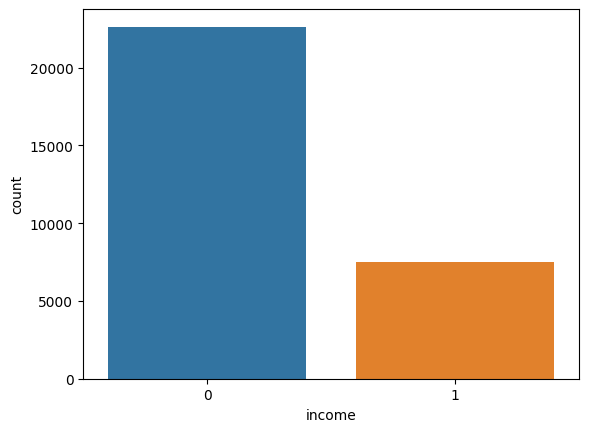

In [416]:
# Plot income
sns.countplot(data=df, x='income')

In [417]:
df['income'].value_counts()

0    22633
1     7506
Name: income, dtype: int64

Probability of >50k income based on the dataset is ~25%. Thus, anything deviating from this significantly in the graphs (after the heatmap) could possibly be used in modeling.

<AxesSubplot: >

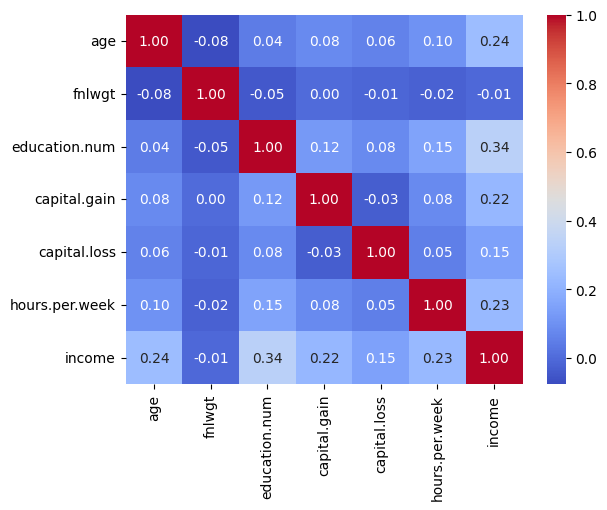

In [418]:
# Plot correlations
sns.heatmap(df[num_features].corr(), cmap = "coolwarm", annot=True, fmt = ".2f")

[Text(0.5, 0, 'Education Grade'), Text(0, 0.5, '>=50k Probability')]

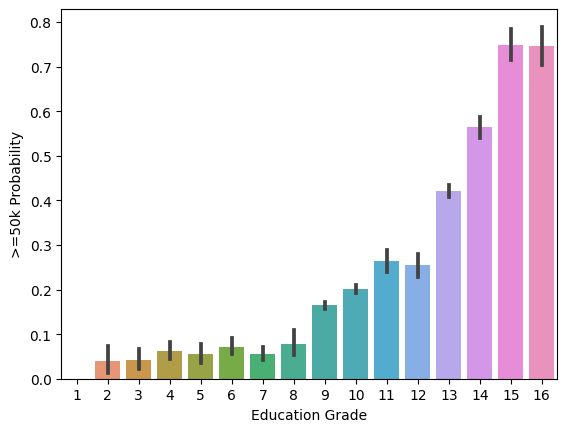

In [419]:
# Explore education
edu_vs_inc = sns.barplot(x='education.num', y='income', data=df)
edu_vs_inc.set(xlabel ="Education Grade", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Hours per Week'), Text(0, 0.5, '>=50k Probability')]

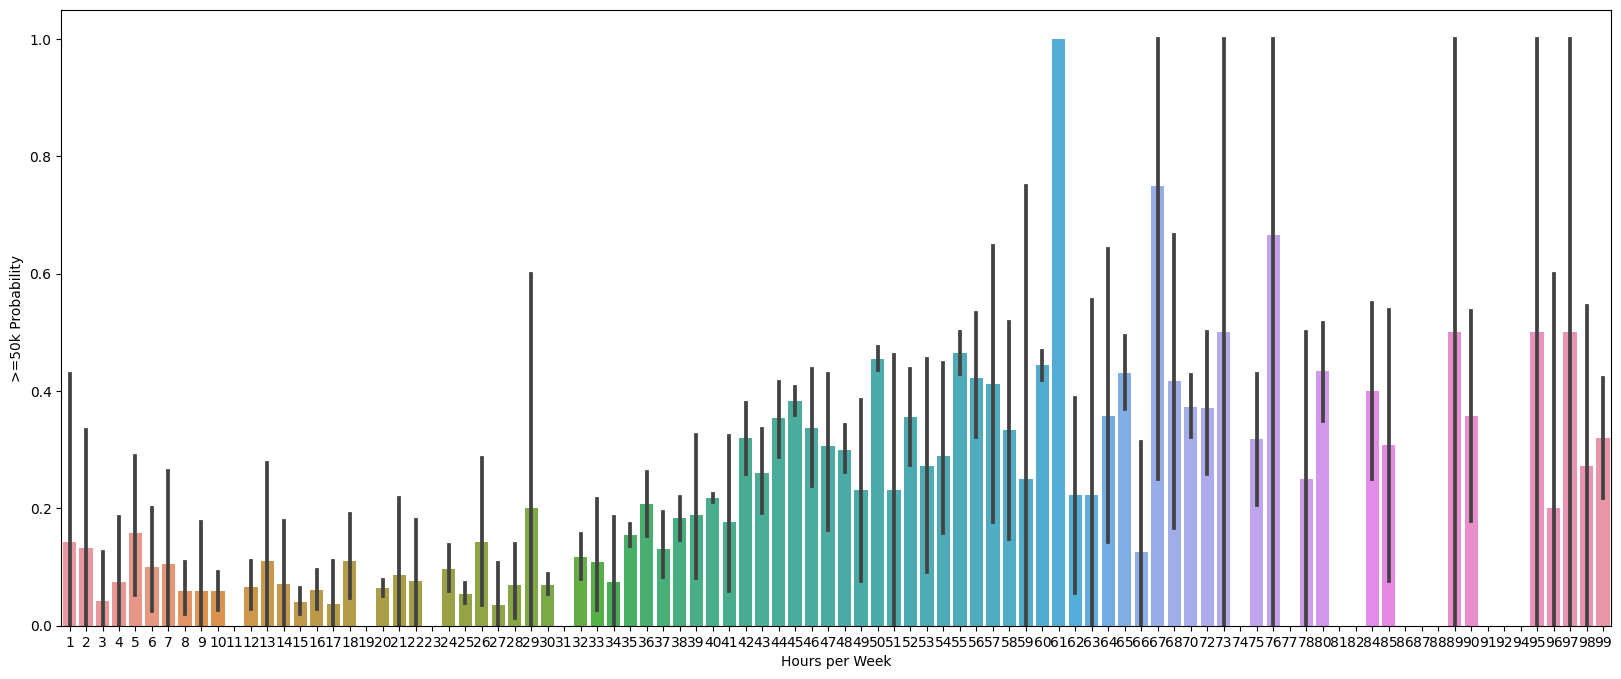

In [420]:
# Explore hours per week
plt.figure(figsize=(20,8))
hours_vs_inc = sns.barplot(x='hours.per.week', y='income', data=df)
hours_vs_inc.set(xlabel ="Hours per Week", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Age'), Text(0, 0.5, '>=50k Probability')]

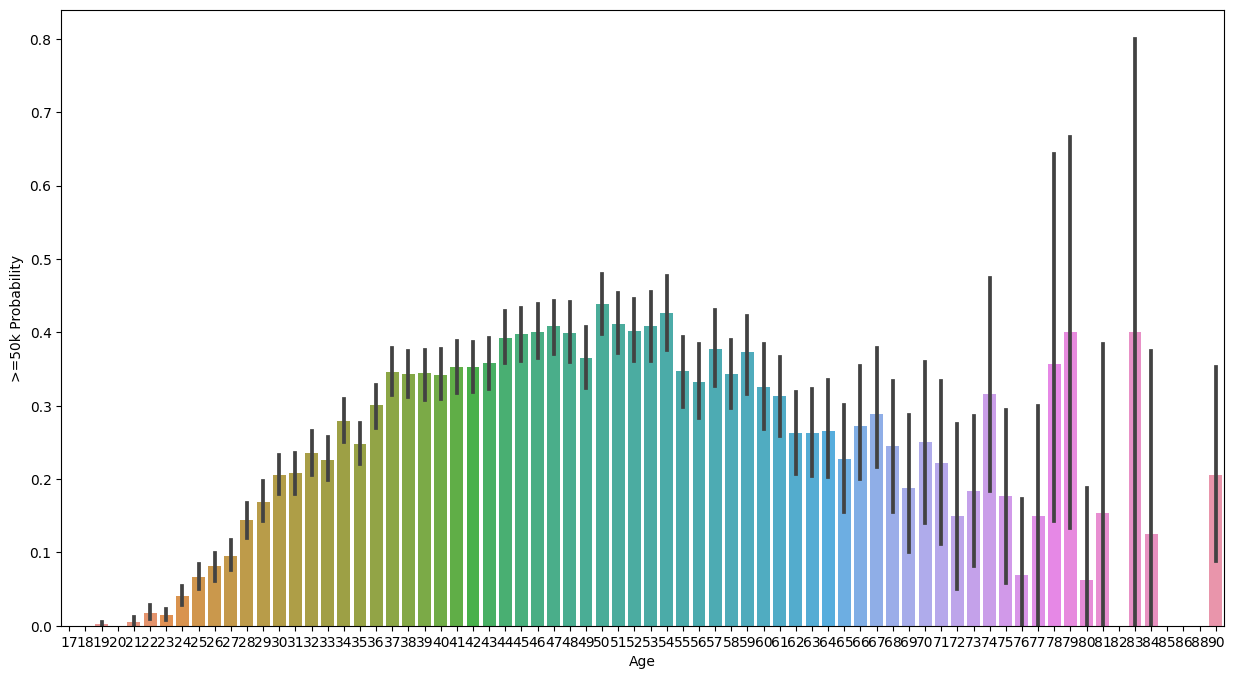

In [421]:
# Explore age
plt.figure(figsize=(15,8))
age_vs_inc = sns.barplot(x='age', y='income', data=df)
age_vs_inc.set(xlabel ="Age", ylabel = ">=50k Probability")

Age, hours per week, and education grade appear to correlate somewhat with income, as expected.

[Text(0.5, 0, 'Country'), Text(0, 0.5, '>=50k Probability')]

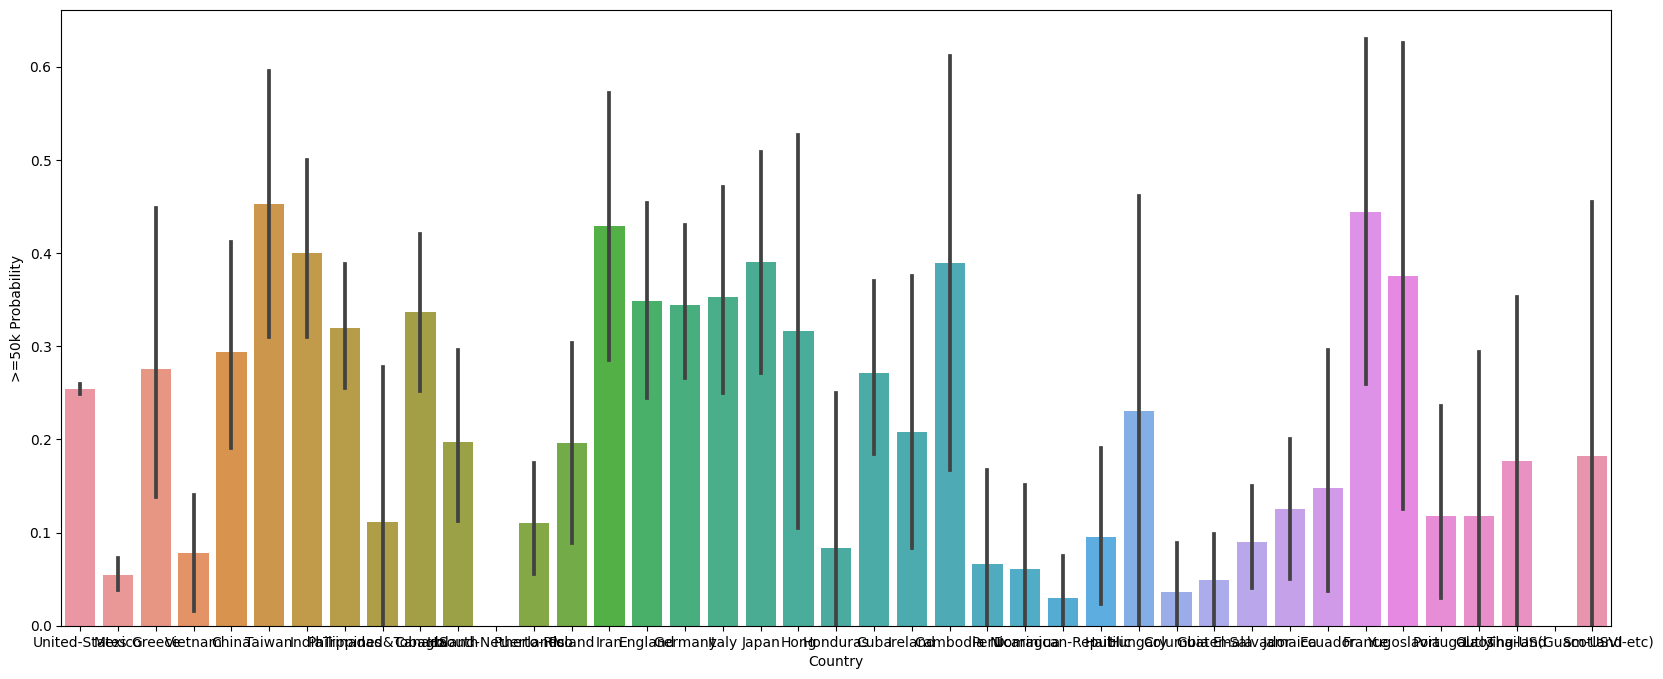

In [422]:
# Explore native country
plt.figure(figsize=(20,8))
nat_vs_inc = sns.barplot(x='native.country', y='income', data=df)
nat_vs_inc.set(xlabel ="Country", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Sex'), Text(0, 0.5, '>=50k Probability')]

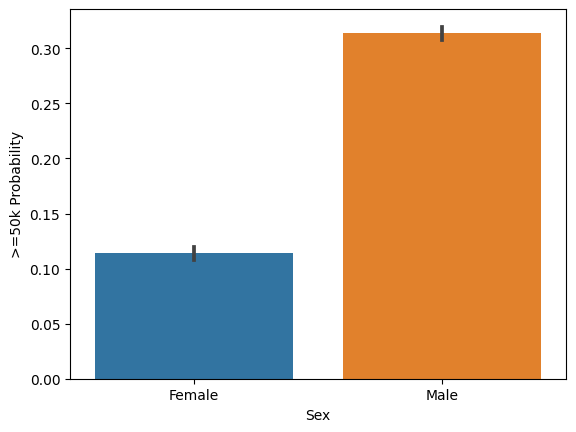

In [423]:
# Explore sex
sex_vs_inc = sns.barplot(x='sex', y='income', data=df)
sex_vs_inc.set(xlabel ="Sex", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Relationship'), Text(0, 0.5, '>=50k Probability')]

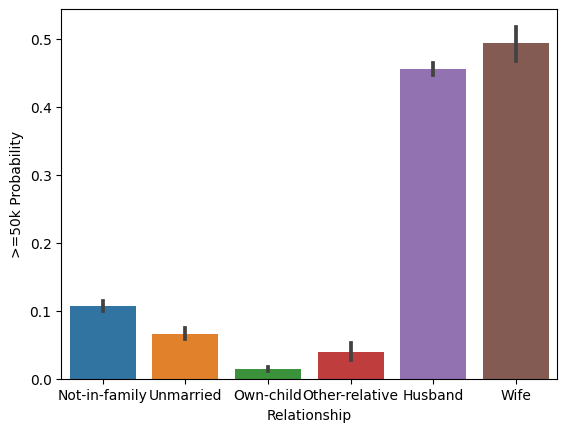

In [424]:
# Explore relationship
rel_vs_inc = sns.barplot(x='relationship', y='income', data=df)
rel_vs_inc.set(xlabel ="Relationship", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Marital Status'), Text(0, 0.5, '>=50k Probability')]

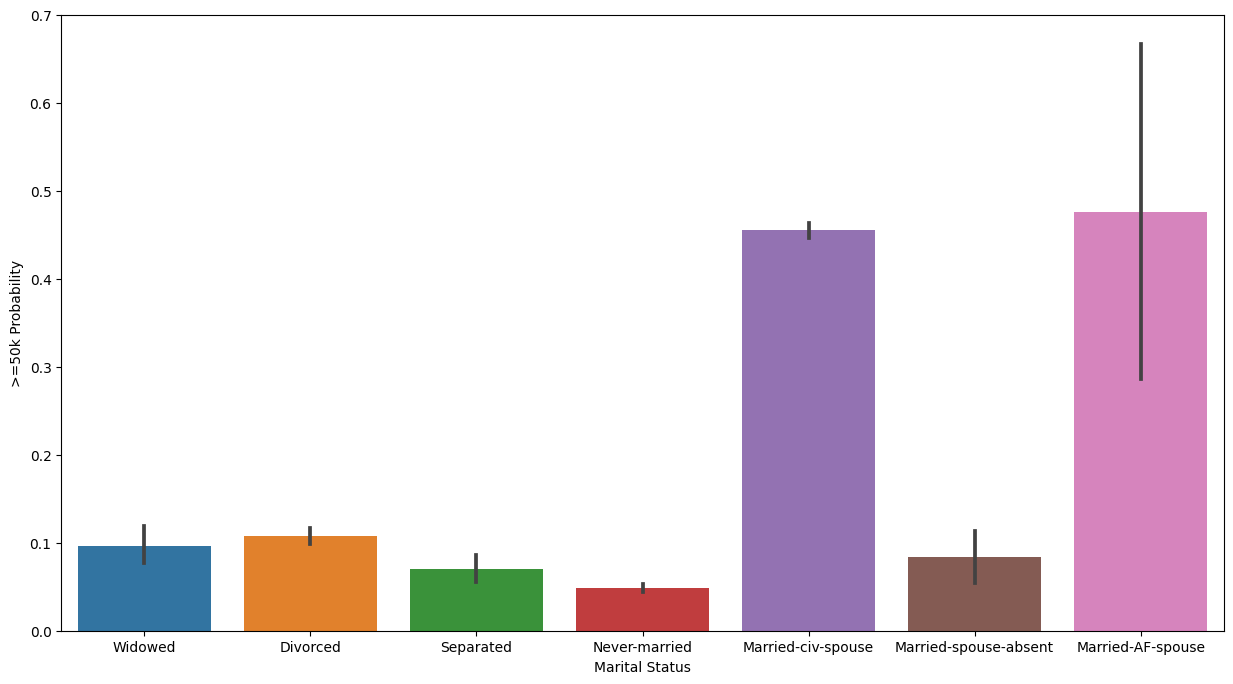

In [425]:
# Explore marital status
plt.figure(figsize=(15,8))
marital_vs_inc = sns.barplot(x='marital.status', y='income', data=df)
marital_vs_inc.set(xlabel ="Marital Status", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Sector'), Text(0, 0.5, '>=50k Probability')]

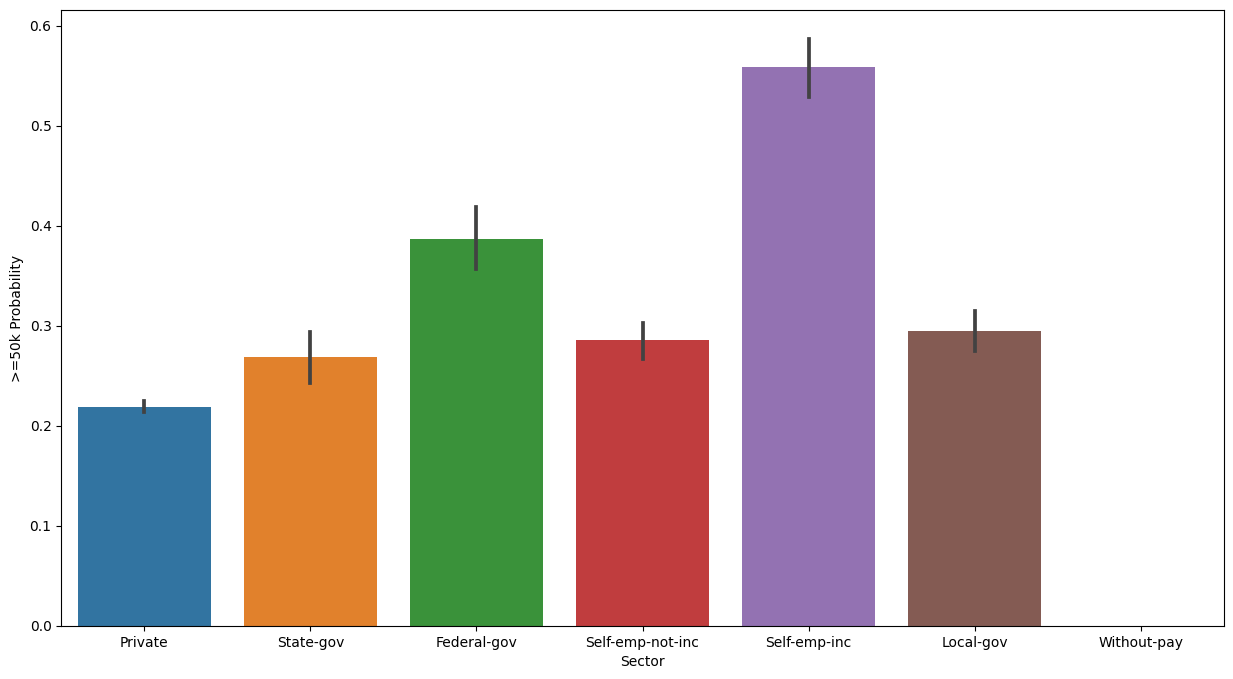

In [426]:
# Explore sector
plt.figure(figsize=(15,8))
sect_vs_inc = sns.barplot(x='workclass', y='income', data=df)
sect_vs_inc.set(xlabel ="Sector", ylabel = ">=50k Probability")

[Text(0.5, 0, 'Occupation'), Text(0, 0.5, '>=50k Probability')]

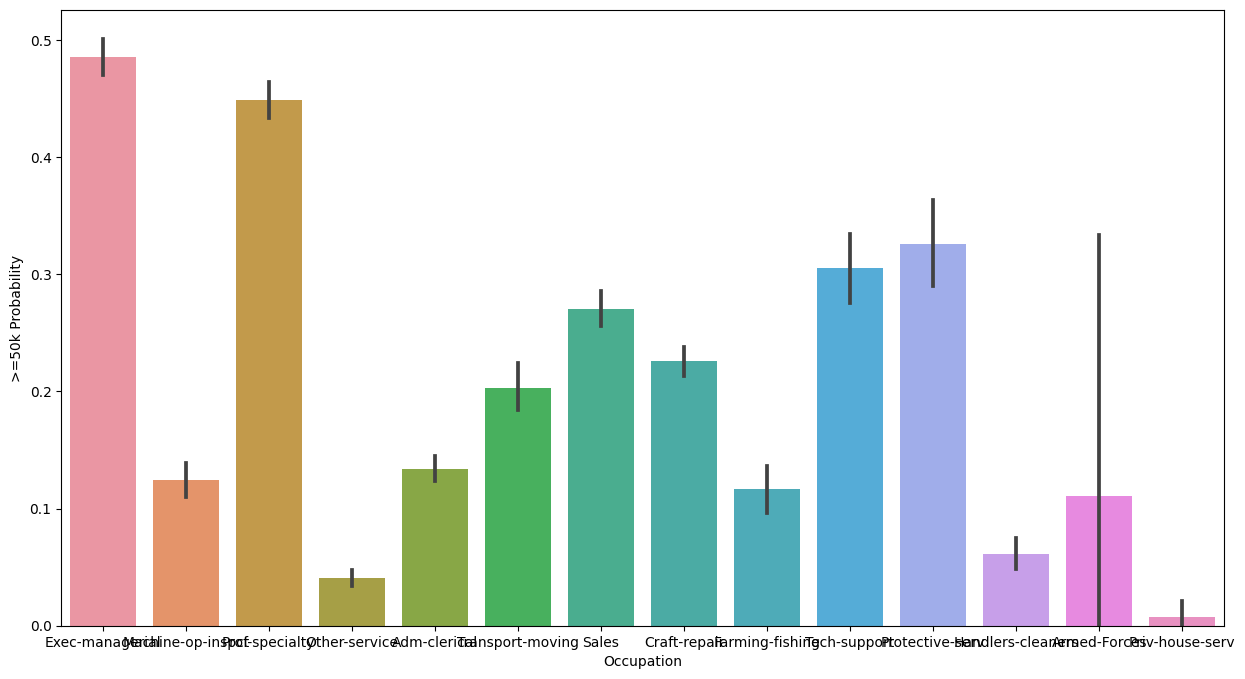

In [427]:
# Explore occupation
plt.figure(figsize=(15,8))
occ_vs_inc = sns.barplot(x='occupation', y='income', data=df)
occ_vs_inc.set(xlabel ="Occupation", ylabel = ">=50k Probability")

Sex and Marital Status appear to impact probability of >50k, while the other categorical variables are mostly a wash.

4. Feature Selections

From the graphs:
Occupation, workclass, native country, and race appear either unusable or difficult to transform into dummy variables (many categories around the .25 probability mark).
Education and relationship appear redudent with education.num and marital.status

Transform into dummy variables:

In [428]:
print(df['occupation'].unique())
print(df['marital.status'].unique())

['Exec-managerial' 'Machine-op-inspct' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Transport-moving' 'Sales' 'Craft-repair'
 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Handlers-cleaners'
 'Armed-Forces' 'Priv-house-serv']
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']


In [429]:
df['sex'] = df['sex'].map({"Male": 0, "Female": 1})

df["marital.status"] = df["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
df["marital.status"] = df["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
df["marital.status"] = df["marital.status"].map({"Married":1, "Single":0})
df["marital.status"] = df["marital.status"].astype(int)

df.drop(labels=["workclass",'occupation', "education","relationship","race","native.country"], axis = 1, inplace = True)

df.head(4)

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
1,82,132870,9,0,1,0,4356,18,0
3,54,140359,4,0,1,0,3900,40,0
4,41,264663,10,0,1,0,3900,40,0
5,34,216864,9,0,1,0,3770,45,0


5. Model

Split variables into Independent and Dependent:

In [430]:
X = df[['age', 'fnlwgt', 'education.num', 'marital.status', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week']] 
y = df['income']

Split data into train and test:

In [431]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

Logistic Regression:

In [432]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lrscore = model.score(X_test, y_test)
print("Logistic Regression Accuracy:", lrscore)

Logistic Regression Accuracy: 0.7928002654280026


Linear Discriminant Analysis:

In [433]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
ldscore = model.score(X_test, y_test)
print("Linear Discriminant Analysis Accuracy:", ldscore)

Linear Discriminant Analysis Accuracy: 0.8261446582614466


K-Nearest Neighbors:

In [434]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
knscore = model.score(X_test, y_test)
print("K-NN Accuracy:", knscore)

K-NN Accuracy: 0.7715660252156602


Decision Tree Classifier:

In [435]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
dtscore = model.score(X_test, y_test)
print("Decision Tree Accuracy:", dtscore)

Decision Tree Accuracy: 0.8020902455209025


Naive Bayes Classifier:

In [436]:
from sklearn.naive_bayes import GaussianNB
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
nbscore = model.score(X_test, y_test)
print("Naive Bayes Accuracy:", nbscore)

Naive Bayes Accuracy: 0.8059057730590578


Random Forest:

In [437]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
rfscore = model.score(X_test, y_test)
print("Random Forest Accuracy:", rfscore)

Random Forest Accuracy: 0.8414067684140677


Analyze results of models:

[Text(0.5, 0, 'Model'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Algorithm Comparison')]

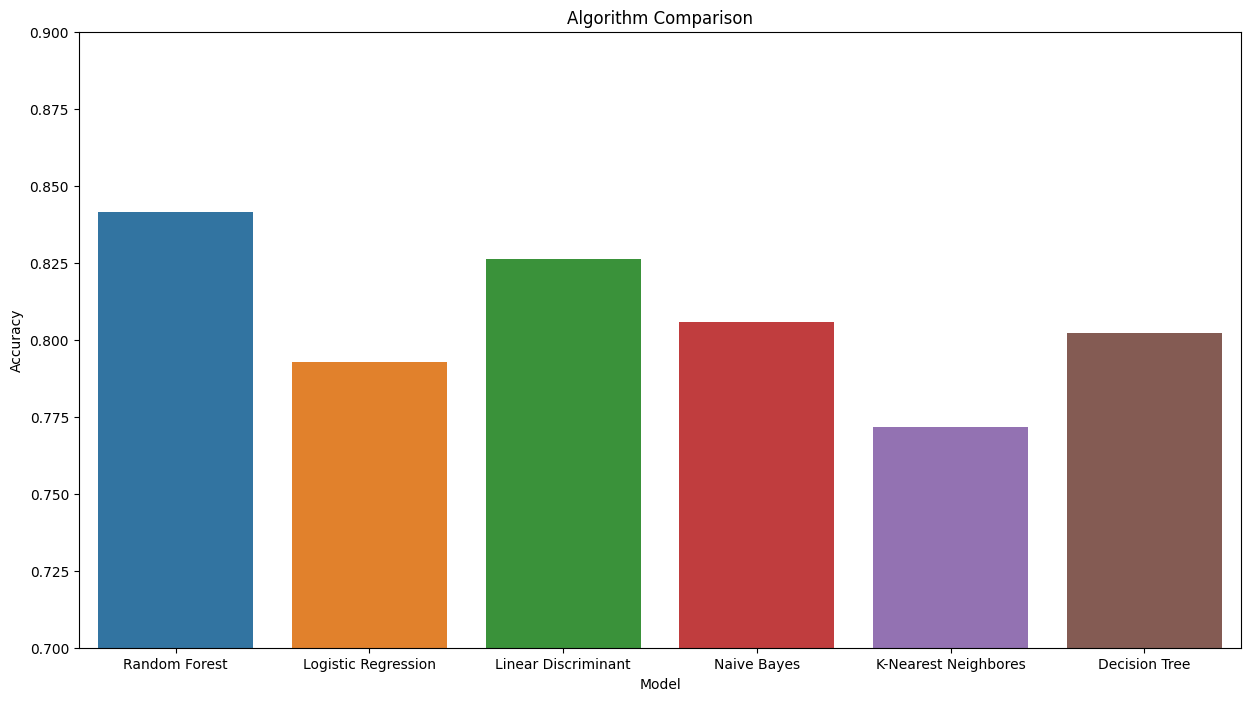

In [438]:
plt.figure(figsize=(15,8))
plt.ylim(.7, .9)
models = ['Random Forest', 'Logistic Regression', 'Linear Discriminant', 'Naive Bayes', 'K-Nearest Neighbores', 'Decision Tree']
model_scores = [rfscore, lrscore, ldscore, nbscore, knscore, dtscore]
sect_vs_inc = sns.barplot(x=models, y=model_scores)
sect_vs_inc.set(xlabel ="Model", ylabel = "Accuracy", title="Algorithm Comparison")

6. Tune the Model

In [439]:
# Fine Tuning
from sklearn.model_selection import GridSearchCV
# Create the parameter grid
param_grid = {
    'max_features': [1, 2, 3, 4, 5],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}
# Create the classifier model
rfmodel = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfmodel, param_grid = param_grid, 
                          cv = 3, scoring='accuracy')
# Fit and score the model
rfmodel = grid_search.fit(X_train, y_train)
accuracy = grid_search.score(X_test, y_test)

An improvement of around 0.5%. Furthermore refinement might help, but it would have diminishing returns.

7. Finalize the model

In [440]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
prediction = rfmodel.predict(X_test)
print("Conclusion:")
print("I was able to predict whether income was above 50k per year based on the dataset using a Random Forest model with:")
print("Accuracy: %s%%" % (100*accuracy_score(y_test, prediction)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

Conclusion:
I was able to predict whether income was above 50k per year based on the dataset using a Random Forest model with:
Accuracy: 84.22362309223624%
[[4187  372]
 [ 579  890]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4559
           1       0.71      0.61      0.65      1469

    accuracy                           0.84      6028
   macro avg       0.79      0.76      0.77      6028
weighted avg       0.84      0.84      0.84      6028

